In [143]:
import numpy as np # For numerical computation
import pandas as pd # Data manipulation
import seaborn as sns # plotting
import scipy.io # reading matlab files in python
from scipy import signal #signal processing
from scipy.fftpack import fft, dct #signal processing

from sklearn.linear_model import LinearRegression #linear regression model
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import KFold, train_test_split # cross validation split
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')

from matplotlib import pyplot as plt # For plotting graphs(Visualization)

import os # system-wide functions
import socketio

In [144]:
datapath = "E:/dataset/UCI_PPG"

In [145]:

def load_data_partial(filename):
  mat_contents = sio.loadmat(filename) 

  return mat_contents

In [146]:
import os
import scipy.io

def load_data(fileDir, exercise):
    word = exercise.lower()
    valid_file_extensions = [".mat"]

    # 파일 경로 리스트 생성
    file_path_list = [
        os.path.join(fileDir, file)
        for file in os.listdir(fileDir)
        if os.path.splitext(file)[1].lower() in valid_file_extensions
    ]

    Data = []
    for path in file_path_list:
        base = os.path.splitext(os.path.basename(path))[0]
        if word in base:
            print(os.path.join(fileDir, base))
            mat_contents = scipy.io.loadmat(os.path.join(fileDir, base + ".mat"))
            val = mat_contents.get("p")  # 안전하게 가져오기
            if val is not None:
                total_array = val[0, :]  # assigning an array
                Data.append(total_array)

    return Data


In [147]:
word = 'part'
total_data = load_data(datapath, word)

E:/dataset/UCI_PPG\part_7


In [148]:
print("리스트 길이:", len(total_data))  # 리스트의 요소 개수
print("첫 번째 요소 타입:", len(total_data[0]))  # 첫 번째 요소의 데이터 타입
print("마지막 요소 타입:", type(total_data[-1]))  # 마지막 요소의 데이터 타입


리스트 길이: 1
첫 번째 요소 타입: 1000
마지막 요소 타입: <class 'numpy.ndarray'>


In [149]:
import numpy as np

# 빈 리스트 초기화
ecg = []
bp = []
ppg = []
sbp = []  # Systolic Blood Pressure (수축기 혈압)
dbp = []  # Diastolic Blood Pressure (이완기 혈압)
size = 125  # 샘플링 125Hz

num_samples = len(total_data)  # 12개의 샘플 그룹

# 각 샘플 그룹(12개)을 순회
for sample_idx in range(num_samples):
    temp_mat = total_data[sample_idx]  # 현재 샘플 그룹 선택 (shape: (1000, 3, 61000) 예상)
    
    for i in range(1000):  # 각 샘플 그룹 내 1000개의 데이터 순회
        temp_data = np.squeeze(temp_mat[i])  # 불필요한 차원 제거 (예: (3, 61000) 유지)

        if temp_data.shape[0] != 3:  # 데이터 차원 확인
            print(f"Error: Unexpected shape {temp_data.shape} at sample {sample_idx}, index {i}")
            continue  # 잘못된 차원의 데이터는 건너뜀

        temp_length = temp_data.shape[1]  # 데이터 길이 확인 (61000)

        for j in range(temp_length // size):  # 125개씩 나누어 처리
            temp_ppg = temp_data[0, j*size:(j+1)*size]  # PPG 데이터 추출
            temp_bp = temp_data[1, j*size:(j+1)*size]   # ABP 데이터 추출
            temp_ecg = temp_data[2, j*size:(j+1)*size]  # ECG 데이터 추출

            max_value = max(temp_bp)  # 수축기 혈압(SBP)
            min_value = min(temp_bp)  # 이완기 혈압(DBP)

            # 리스트에 저장
            ppg.append(temp_ppg)
            bp.append(temp_bp)
            ecg.append(temp_ecg)
            sbp.append(max_value)
            dbp.append(min_value)

# 결과 확인
print(f"PPG 데이터 개수: {len(ppg)}")
print(f"ABP 데이터 개수: {len(bp)}")
print(f"ECG 데이터 개수: {len(ecg)}")
print(f"SBP 데이터 개수: {len(sbp)}")   # BP 125개마다 생성
print(f"DBP 데이터 개수: {len(dbp)}")   # BP 125개마다 생성



PPG 데이터 개수: 123888
ABP 데이터 개수: 123888
ECG 데이터 개수: 123888
SBP 데이터 개수: 123888
DBP 데이터 개수: 123888


In [151]:
import numpy as np

array_data = np.array(ppg)  # NumPy 배열로 변환
print(array_data.shape)  


(123888, 125)


In [152]:
# Reshaping the ecg, ppg and bp signal data into column vectors
ppg, ecg, bp = np.array(ppg).reshape(-1,1), np.array(ecg).reshape(-1,1), np.array(bp).reshape(-1,1)
sbp, dbp = np.array(sbp).reshape(-1,1), np.array(dbp).reshape(-1,1)
print(f'PPG_shape: {ppg.shape}\n ECG_shape: {ecg.shape}\n BP_shape: {bp.shape}')
print(f'Systolic-BP_shape: {sbp.shape},\n Diastolic-BP_shape: {dbp.shape}')

PPG_shape: (15486000, 1)
 ECG_shape: (15486000, 1)
 BP_shape: (15486000, 1)
Systolic-BP_shape: (123888, 1),
 Diastolic-BP_shape: (123888, 1)


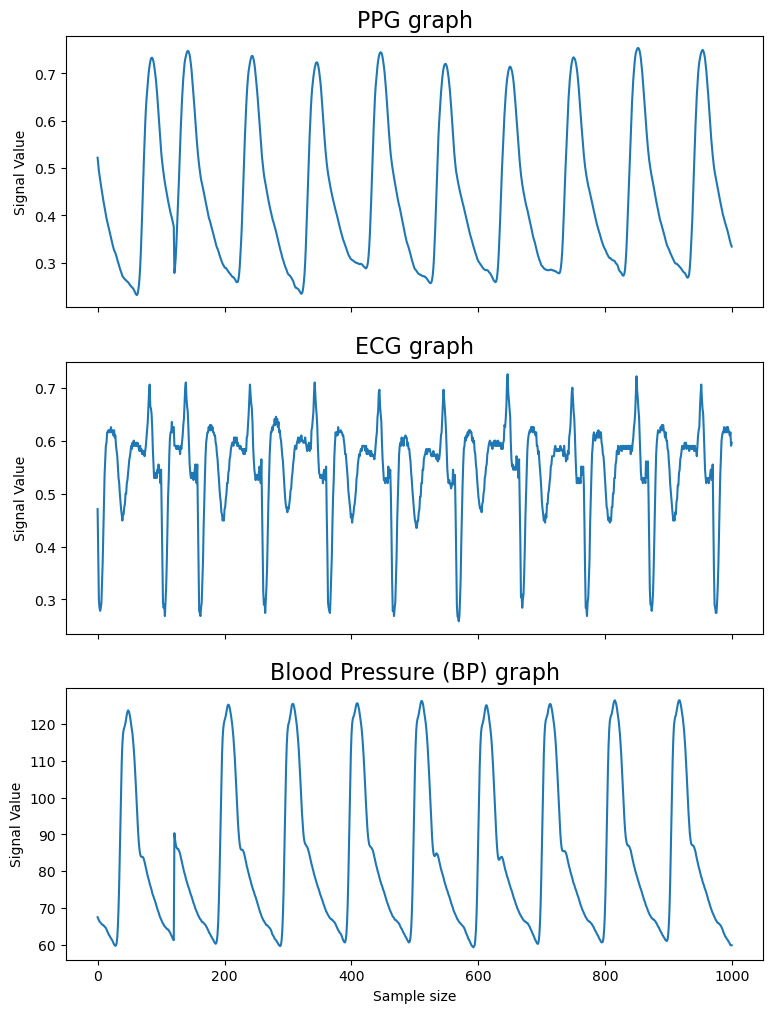

In [153]:
fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:1000])

ax[1].set_title('ECG graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(ecg[:1000])

ax[2].set_title('Blood Pressure (BP) graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(bp[:1000])

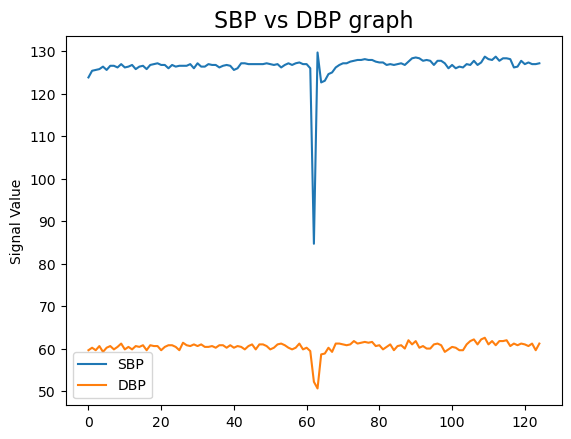

In [154]:
## Visualizing SBP and DBP
#fig, ax = plt.subplots(1,1, figsize=(9,12))

plt.title('SBP vs DBP graph', fontsize=16)
plt.ylabel('Signal Value')
plt.plot(sbp[:125])
plt.plot(dbp[:125])
plt.legend(['SBP', 'DBP'])

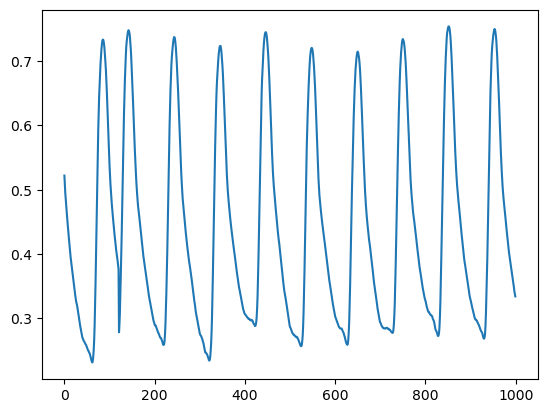

In [155]:
plt.plot(ppg[:1000].squeeze())

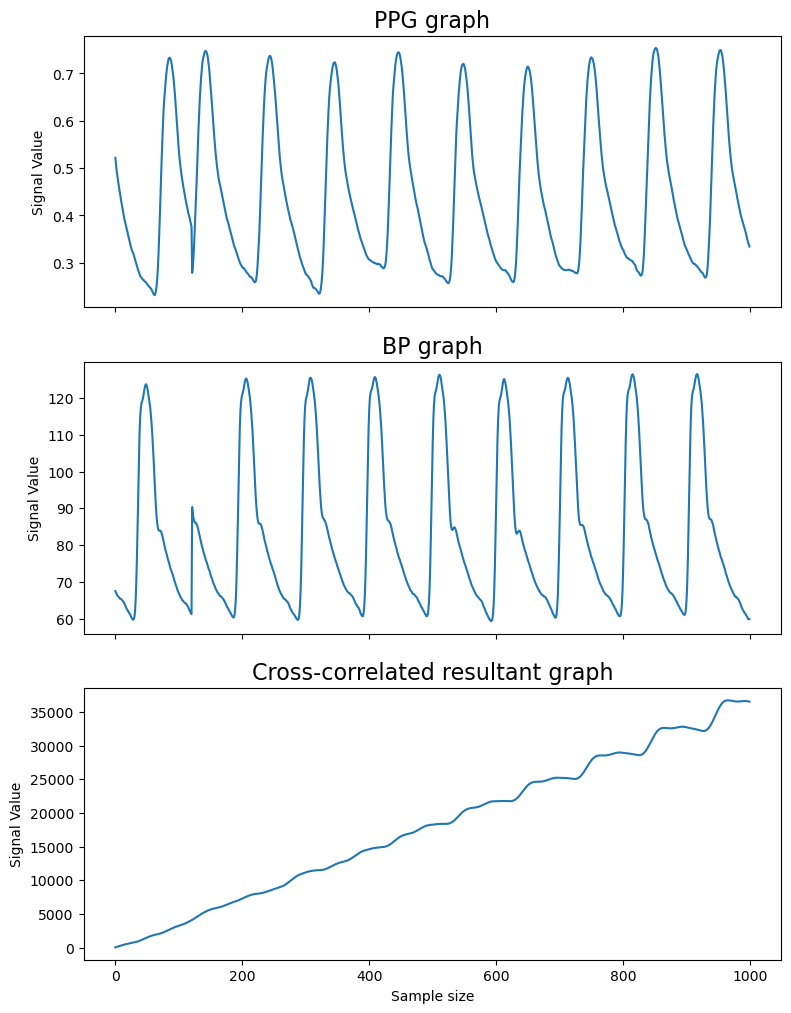

In [156]:
# Computing the cross correlation of ppg and bp signals
cross_corr = np.convolve(ppg[:1000].squeeze(), bp[:1000].squeeze(), mode='full')

fig, ax = plt.subplots(3,1, figsize=(9,12), sharex=True)

ax[0].set_title('PPG graph', fontsize=16)
ax[0].set_ylabel('Signal Value')
ax[0].plot(ppg[:1000])

ax[1].set_title('BP graph', fontsize=16)
ax[1].set_ylabel('Signal Value')
ax[1].plot(bp[:1000])

ax[2].set_title('Cross-correlated resultant graph', fontsize=16)
ax[2].set_ylabel('Signal Value')
ax[2].set_xlabel('Sample size')
ax[2].plot(cross_corr[:1000])

In [157]:
# defining our evaluation error function
def rmse(y_true, y_pred):
    """Computes the Root Mean Squared Error (RMSE)."""
    return np.sqrt(mean_squared_error(y_true, y_pred))

In [158]:
#Computing the discrete cosine transform (DCT)
cosine_transformed_array = dct(ppg)
error = rmse(bp.squeeze(), cosine_transformed_array.squeeze())
print(f'RMSE: {error}')


RMSE: 83.53128900992523


In [159]:
bp.shape

(15486000, 1)

In [160]:
# creating train and test sets
X_train, X_test, y_train, y_test = train_test_split(ppg, bp, test_size=0.30)

In [161]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((10840200, 1), (4645800, 1), (10840200, 1), (4645800, 1))

In [162]:
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error

In [163]:
#Linear Regression with Values of PPG
import numpy as np
from sklearn.linear_model import LinearRegression
linear_model_std = LinearRegression()
linear_model_std.fit(X_train, y_train)

LinearRegression()

In [164]:
y_pred = linear_model_std.predict(X_test)

In [165]:
rmse= np.sqrt(np.mean((y_pred-y_test)**2))
print(f'LR standard model RMSE is: {rmse}')

LR standard model RMSE is: 23.437636787375684


In [168]:
import numpy as np

def sliding_window_transform(X, y, window_size, step):
    """
    X, y 데이터를 슬라이딩 윈도우 방식으로 변환 (50% 중첩)
    
    :param X: (samples, features) 형태의 NumPy 배열
    :param y: (samples,) 또는 (samples, labels) 형태의 NumPy 배열
    :param window_size: 윈도우 크기 (예: 125)
    :param step: 윈도우 이동 크기 (예: 62 = 50% 중첩)
    :return: 변환된 (윈도우 개수, window_size, features) 형태의 X, (윈도우 개수,) 또는 (윈도우 개수, labels) 형태의 y
    """
    num_windows = (len(X) - window_size) // step + 1  # 가능한 윈도우 개수

    X_windows = np.array([X[i : i + window_size] for i in range(0, len(X) - window_size + 1, step)])
    y_windows = np.array([y[i + window_size - 1] for i in range(0, len(y) - window_size + 1, step)])

    return X_windows, y_windows

In [170]:
# ✅ 슬라이딩 윈도우 적용 (50% 중첩)
window_size = 125  # 1초 크기
step = window_size // 2  # 50% 중첩 (62)

X_train_transformed, y_train_transformed = sliding_window_transform(X_train, y_train, window_size, step)
X_test_transformed, y_test_transformed = sliding_window_transform(X_test, y_test, window_size, step)

# ✅ 변환된 데이터 크기 확인
print(f"X_train: {X_train.shape} -> {X_train_transformed.shape}")
print(f"y_train: {y_train.shape} -> {y_train_transformed.shape}")
print(f"X_test: {X_test.shape} -> {X_test_transformed.shape}")
print(f"y_test: {y_test.shape} -> {y_test_transformed.shape}")

X_train: (10840200, 1) -> (174840, 125, 1)
y_train: (10840200, 1) -> (174840, 1)
X_test: (4645800, 1) -> (74931, 125, 1)
y_test: (4645800, 1) -> (74931, 1)


In [181]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, BatchNormalization, ReLU, Dropout, GlobalAveragePooling1D, Dense
from tensorflow.keras.optimizers import Adam

def build_cnn_regression_model(input_shape):
    """
    회귀 문제를 위한 1D CNN 모델을 생성하는 함수
    
    :param input_shape: 입력 데이터의 형태 (window_size, features)
    :return: CNN 모델
    """
    model = Sequential([
        # Conv1D Layer 1
        Conv1D(filters=32, kernel_size=3, padding='same', activation=None, input_shape=input_shape),
        BatchNormalization(),
        ReLU(),
        Dropout(0.2),

        # Conv1D Layer 2
        Conv1D(filters=64, kernel_size=3, padding='same', activation=None),
        BatchNormalization(),
        ReLU(),
        Dropout(0.3),

        # Conv1D Layer 3
        Conv1D(filters=128, kernel_size=3, padding='same', activation=None),
        BatchNormalization(),
        ReLU(),
        Dropout(0.4),

        # Global Average Pooling
        GlobalAveragePooling1D(),

        # Fully Connected Layer
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(1, activation='linear')  # ⬅ 회귀 문제이므로 출력 노드는 1개 + activation='linear'
    ])

    return model

# ✅ 모델 생성
window_size = 125  # 윈도우 크기
num_features = 1  # 특성 수

model = build_cnn_regression_model((window_size, num_features))

# ✅ 모델 컴파일 (손실 함수: MSE 또는 MAE)
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='mse',  # 회귀 문제에서는 MSE (Mean Squared Error) 사용
    metrics=['mae']  # 추가 평가 지표로 MAE 사용 가능
)

# ✅ 모델 요약 정보 출력
model.summary()


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv1d_9 (Conv1D)                    │ (None, 125, 32)             │             128 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_9                │ (None, 125, 32)             │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_9 (ReLU)                       │ (None, 125, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_24 (Dropout)                 │ (None, 125, 32)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_10 (Conv1D)                   │ (None, 125, 64)             │           6,208 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 125, 64)             │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_10 (ReLU)                      │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_25 (Dropout)                 │ (None, 125, 64)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_11 (Conv1D)                   │ (None, 125, 128)            │          24,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 125, 128)            │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ re_lu_11 (ReLU)                      │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_26 (Dropout)                 │ (None, 125, 128)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d_3           │ (None, 128)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_22 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_27 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_23 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 40,257 (157.25 KB)

 Trainable params: 39,809 (155.50 KB)

 Non-trainable params: 448 (1.75 KB)

In [182]:
# ✅ y_train, y_test의 차원이 (N,)이면 (N, 1)로 변환
y_train_transformed = y_train_transformed.reshape(-1, 1) if y_train_transformed.ndim == 1 else y_train_transformed
y_test_transformed = y_test_transformed.reshape(-1, 1) if y_test_transformed.ndim == 1 else y_test_transformed

print(f"X_train shape: {X_train_transformed.shape}, y_train shape: {y_train_transformed.shape}")
print(f"X_test shape: {X_test_transformed.shape}, y_test shape: {y_test_transformed.shape}")


X_train shape: (174840, 125, 1), y_train shape: (174840, 1)
X_test shape: (74931, 125, 1), y_test shape: (74931, 1)


In [184]:
# ✅ CNN 모델 학습 (회귀 문제)
history = model.fit(
    X_train_transformed, y_train_transformed,
    validation_data=(X_test_transformed, y_test_transformed),
    epochs=10,
    batch_size=32
)

Epoch 1/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 124s 23ms/step - loss: 749.3932 - mae: 21.2380 - val_loss: 555.3314 - val_mae: 17.6109
Epoch 2/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 722.2991 - mae: 20.8290 - val_loss: 655.9838 - val_mae: 17.8445
Epoch 3/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 107s 20ms/step - loss: 694.6630 - mae: 20.3652 - val_loss: 705.8167 - val_mae: 18.4327
Epoch 4/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 106s 19ms/step - loss: 678.5607 - mae: 20.0413 - val_loss: 605.2513 - val_mae: 17.1967
Epoch 5/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 105s 19ms/step - loss: 667.0804 - mae: 19.7872 - val_loss: 711.2230 - val_mae: 18.9905
Epoch 6/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 105s 19ms/step - loss: 643.5553 - mae: 19.3568 - val_loss: 592.4996 - val_mae: 17.0846
Epoch 7/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 108s 20ms/step - loss: 623.8350 - mae: 19.0281 - val_loss: 590.7314 - val_mae: 16.9679
Epoch 8/10
5464/5464 ━━━━━━━━━━━━━━━━━━━━ 107s 19ms/step - loss: 617.9755 - mae: 18.8442 - val_lo

2342/2342 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step
🔹 Mean Squared Error (MSE): 552.2234
🔹 Root Mean Squared Error (RMSE): 23.4994
🔹 Mean Absolute Error (MAE): 16.5174
🔹 R² Score: 0.0032


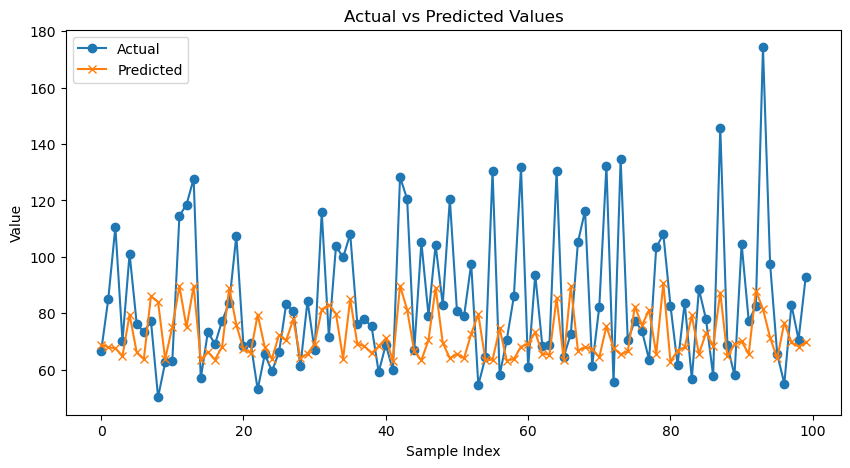

In [185]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ✅ 예측 수행
y_pred = model.predict(X_test_transformed)

# ✅ MSE, RMSE, MAE, R² 계산
mse = mean_squared_error(y_test_transformed, y_pred)
rmse = np.sqrt(mse)  # RMSE는 MSE의 제곱근
mae = mean_absolute_error(y_test_transformed, y_pred)
r2 = r2_score(y_test_transformed, y_pred)

# ✅ 평가 결과 출력
print(f"🔹 Mean Squared Error (MSE): {mse:.4f}")
print(f"🔹 Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"🔹 Mean Absolute Error (MAE): {mae:.4f}")
print(f"🔹 R² Score: {r2:.4f}")

# ✅ 실제 vs 예측값 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(y_test_transformed[:100], label="Actual", marker="o")
plt.plot(y_pred[:100], label="Predicted", marker="x")
plt.xlabel("Sample Index")
plt.ylabel("Value")
plt.title("Actual vs Predicted Values")
plt.legend()
plt.show()



In [137]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [138]:
def Model(input_dim, activation, num_class):
    model = Sequential()

    model.add(Dense(1024, input_dim=input_dim))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(512))
    model.add(Activation(activation))
    model.add(Dropout(0.5))

    model.add(Dense(64))
    model.add(Activation(activation))
    model.add(Dropout(0.25))

    model.add(Dense(num_class))
    model.add(Activation('linear'))

    model.compile(loss='mse',
                  optimizer=optimizers.Adam(learning_rate=0.0001),
                  metrics=['mean_absolute_error']
                 )
    return model

#loss='huber'

In [139]:
input_dim = X_train.shape[1]
activation = 'relu'
classes = 1
model = Model(input_dim=input_dim, activation=activation, num_class=classes)
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_12 (Dense)                     │ (None, 1024)                │           2,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_12 (Activation)           │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_9 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_13 (Activation)           │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_10 (Dropout)                 │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │          32,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_14 (Activation)           │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_11 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 1)                   │              65 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_15 (Activation)           │ (None, 1)                   │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 559,745 (2.14 MB)

 Trainable params: 559,745 (2.14 MB)

 Non-trainable params: 0 (0.00 B)

In [141]:
history = model.fit(X_train, y_train,
                    epochs=5,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/5
84690/84690 ━━━━━━━━━━━━━━━━━━━━ 637s 8ms/step - loss: 609.3245 - mean_absolute_error: 19.2181
Epoch 2/5
36767/84690 ━━━━━━━━━━━━━━━━━━━━ 5:49 7ms/step - loss: 540.4316 - mean_absolute_error: 17.6341

KeyboardInterrupt: 

In [ ]:
plt.title('Train loss against mean_absolute_error')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.plot(history.history['loss'])
plt.plot(history.history['mean_absolute_error'])
plt.legend(['Loss', 'Mean_absolute_error'])

In [ ]:
# Visualize predicted BP and the True BP
plt.title("===True BP values Vs Predicted BP values===")
plt.xlabel('Number of samples taken')
plt.ylabel('BP values')
plt.plot(y_test[:100]) #only plotting 100 samples
plt.plot(nn_predictions[:100])
plt.legend(['True_BP', 'Predicted_BP'])

In [ ]:
def split_sequence(sequence, n_steps_in, n_steps_out):
    X, y = [], []
    for i in range(len(sequence) - n_steps_in - n_steps_out + 1):
        X.append(sequence[i:i + n_steps_in])
        y.append(sequence[i + n_steps_in : i + n_steps_in + n_steps_out])
    return np.array(X), np.array(y)
    
X, y = split_sequence(ppg_data, n_steps_in=250, n_steps_out=1)

In [ ]:
# Predicting on the test set
test_predictions = model.predict(X_test[:1000000]) #predicting on the first 1million rows for speed.
test_error = rmse(y_test[:1000000], test_predictions)
print(f'Error on test set predictions: {test_error}')

In [ ]:
# Visualizing train error.
fig, ax = plt.subplots(1,2, figsize=(16,6))
ax[0].set_title("=======Training error=======")
ax[0].set_xlabel('Number of folds')
ax[0].set_ylabel('Error values')
ax[0].plot(scores)

# Visualize predicted BP and the True BP
ax[1].set_title("===True BP values Vs Predicted BP values===")
ax[1].set_xlabel('Number of samples taken')
ax[1].set_ylabel('BP values')
ax[1].plot(val_target[:100]) #only plotting 100 samples
ax[1].plot(val_predictions[:100])
ax[1].legend(['True_BP', 'Predicted_BP'])

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers

In [53]:
def normalise(x):
  normalised = (x-min(x))/(max(x)-min(x))
  return normalised

def scale_abp(x):
  normalised = x/200
  return normalised

def normalise_abp(abp, x_max, x_min):
  normalised = (abp-x_min)/(x_max-x_min)
  return normalised

def abp_maxmin_value(x):
  max_x = []
  min_x = []
  for i in range(len(x)):
    for j in range(len(x[i])):
      max_x.append(max(x[i][j][1,:]))
      min_x.append(min(x[i][j][1,:]))
  x_max = max(max_x)
  x_min = min(min_x)

  return x_max, x_min

In [54]:
x_max, x_min = abp_maxmin_value(total_data)
print(x_max, x_min)
x_max = 200.0
x_min = 50.0

199.98749589709124 50.0


In [57]:
# creating train and val sets
X_train, X_test, y_train, y_test = train_test_split(PPG_N, ABP_N, test_size=0.30)

In [58]:
#Linear Regression with Normalized Values of PPG
import numpy as np
from sklearn.linear_model import LinearRegression
linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

LinearRegression()

In [59]:
y_pred = linear_model.predict(X_test)

In [60]:
#Checking MAE error for Linear Regression Model
LR_MAE= tf.keras.metrics.MeanAbsoluteError()
LR_MAE.update_state(y_test, y_pred)
print(f'LR Model MAE: {LR_MAE.result().numpy()}')

LR Model MAE: 0.09289707243442535


In [62]:
#Checking MAP for LR model
score = []
for i in range(len(y_test)):
  score.append(abs(y_test[i]-y_pred[i]))

print("Average MAP error for LR model is: %f mmHG" %(np.mean(score)))

Average MAP error for LR model is: 0.092897 mmHG


In [65]:
# Baseline Sequential Model
from tensorflow.keras import backend as K
K.clear_session() 

def Model(input_dim, num_class):
    model = Sequential()

    model.add(layers.Dense(2048, input_dim = input_dim, activation='sigmoid'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1024, 'relu'))
    model.add(layers.Dropout(0.25))
    model.add(layers.Dense(512, 'relu')) 
    model.add(layers.Dropout(0.25))
    # model.add(layers.Dense(64, 'relu'))    
    # model.add(layers.Dropout(0.25))
    model.add(layers.Dense(num_class, 'linear'))
    
    
    return model

Input_dim = X_train.shape[1]
Classes = 1000


model = Model(input_dim=Input_dim, num_class=Classes)
model.compile(loss=tf.keras.losses.MeanAbsoluteError(),
                  optimizer='adam',
                  metrics=[tf.keras.metrics.RootMeanSquaredError()]
                 )
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 2048)                │       2,050,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 2048)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1024)                │       2,098,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1000)                │         513,000 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 5,186,024 (19.78 MB)

 Trainable params: 5,186,024 (19.78 MB)

 Non-trainable params: 0 (0.00 B)

In [69]:
# Training the ANN model
ANN_model_train = model.fit(X_train, y_train,
                    validation_split=0.1,
                    epochs=30,
                    batch_size=128,
                    verbose = 1
                   )

Epoch 1/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 14s 79ms/step - loss: 0.1819 - root_mean_squared_error: 0.2466 - val_loss: 0.1309 - val_root_mean_squared_error: 0.1815
Epoch 2/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.1302 - root_mean_squared_error: 0.1744 - val_loss: 0.1186 - val_root_mean_squared_error: 0.1616
Epoch 3/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.1219 - root_mean_squared_error: 0.1634 - val_loss: 0.1150 - val_root_mean_squared_error: 0.1575
Epoch 4/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.1173 - root_mean_squared_error: 0.1579 - val_loss: 0.1125 - val_root_mean_squared_error: 0.1527
Epoch 5/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 75ms/step - loss: 0.1153 - root_mean_squared_error: 0.1551 - val_loss: 0.1094 - val_root_mean_squared_error: 0.1486
Epoch 6/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 12s 73ms/step - loss: 0.1130 - root_mean_squared_error: 0.1525 - val_loss: 0.1063 - val_root_mean_squared_error: 0.1455
Epoch 7/30
158/158 ━━━━━━━━━━━━━━━━━━━━ 

In [71]:
#Predicting on the test set using the ANN( artificial neural network) model
ANN_predictions = model.predict(X_test)
rmse = tf.keras.metrics.RootMeanSquaredError()
rmse.update_state(y_test, ANN_predictions)
print(f' ANN Model RMSE: {rmse.result().numpy()}')

301/301 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
 ANN Model RMSE: 0.12591511011123657


In [73]:
X_test.shape

(9619, 1000)

In [72]:
import numpy as np
import matplotlib.pyplot as plt

# ANN_predictions: 모델의 예측값 (numpy array)
# X_test: 실제 값이 포함된 데이터 (numpy array)

# 실제 값 (예제에서는 X_test의 첫 번째 열에 실제 값이 있다고 가정)
true_values = X_test[:, 0]  # 실제 값
predicted_values = ANN_predictions  # 모델의 예측값

# Bland-Altman Plot 데이터 계산
mean_values = (true_values + predicted_values) / 2  # 예측값과 실제값의 평균
errors = predicted_values - true_values  # 오차(예측값 - 실제값)

mean_error = np.mean(errors)  # 평균 오차
std_error = np.std(errors)  # 오차의 표준편차

# 95% 신뢰구간 (±1.96 표준편차)
upper_limit = mean_error + 1.96 * std_error
lower_limit = mean_error - 1.96 * std_error

# 그래프 그리기
plt.figure(figsize=(8, 6))
plt.scatter(mean_values, errors, alpha=0.5, color='cornflowerblue')  # 데이터 포인트
plt.axhline(mean_error, color='blue', linestyle='--', label=f'Mean: {mean_error:.2f} mmHg')  # 평균 오차선
plt.axhline(upper_limit, color='red', linestyle='--', label=f'+1.96 SD: {upper_limit:.2f} mmHg')  # 상한선
plt.axhline(lower_limit, color='red', linestyle='--', label=f'-1.96 SD: {lower_limit:.2f} mmHg')  # 하한선

# 축 및 제목 설정
plt.xlabel('Mean of true and predicted value (mmHg)')
plt.ylabel('Error in Prediction (mmHg)')
plt.title('Bland-Altman Plot for MAP')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6)

# 그래프 출력
plt.show()


ValueError: operands could not be broadcast together with shapes (9619,) (9619,1000) 

In [32]:
def conv_block(x , num_filters):
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.Conv1D(num_filters , kernel_size=3 , strides=1 ,padding="same")(x)
    x = tf.keras.layers.ReLU()(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [37]:
def res_block(x , filters, shortcut_filter):
    y = x 
    for i in filters:
        x = conv_block(x, i)
    x = tf.keras.layers.Dropout(0.4)(x)
    y = tf.keras.layers.Conv1D(shortcut_filter,kernel_size=1 ,padding='same')(y)
    y = tf.keras.layers.ReLU()(y)
    y = tf.keras.layers.BatchNormalization()(y)
    y = tf.keras.layers.Dropout(0.4)(y)
    res = tf.keras.layers.Add()([x, y])
    return res

In [38]:
def sequence_unit(x ,n_units):
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(n_units , activation="tanh",return_sequences=True))(x)
    x = tf.keras.layers.BatchNormalization()(x)
    return x 

In [84]:
def build_model():
    input_ = tf.keras.layers.Input(shape=(sample_size,1))
    y = sequence_unit(input_ , 64)
    y = tf.keras.layers.Dropout(0.5)(y)
    y = sequence_unit(y , 256)
    y = tf.keras.layers.Conv1D(256 ,kernel_size=1 , padding='same', activation="relu")(y)
    x = tf.keras.layers.Conv1D(filters=16 , kernel_size=3 , padding='same')(input_)
    x = res_block(x, [16, 16 , 32], 32)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [32, 64, 64] , 64)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [64 , 128, 128] , 128)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [128,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = res_block(x , [256,256,256] , 256)
    x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.Concatenate()([x,y])
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1 , activation="relu",name ="min")(x)
    out2 = tf.keras.layers.Dense(1 , activation="relu",name ="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min":out1 , "max":out2})
    return model

In [85]:
class HyperLoss(tf.keras.losses.Loss):
    def __init__(self , threshold=4,**kwargs):
        self.threshold = threshold
        super(HyperLoss ,self).__init__(**kwargs)
    def call(self, y_true ,  y_pred):
        error = y_true - y_pred
        is_samll = tf.abs(error)<self.threshold
        square_loss = tf.square(error)/2.0
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2.0
        return tf.where(is_samll , square_loss , linear_loss)
    def get_config(self):
        base_config = super().get_config()
        return {**base_config, "threshold":self.threshold}

In [86]:
model = build_model()
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3) ,
                 loss=HyperLoss() , metrics=["mae"])

In [87]:
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)    │ (None, 64, 1)             │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_77 (Conv1D)            │ (None, 64, 16)            │              64 │ input_layer_3[0][0]        │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_78 (Conv1D)            │ (None, 64, 16)            │             784 │ conv1d_77[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_70 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_78[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_79 (Conv1D)            │ (None, 64, 16)            │             784 │ re_lu_70[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_71 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_79[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_48        │ (None, 64, 16)            │              64 │ re_lu_71[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_80 (Conv1D)            │ (None, 64, 16)            │             784 │ batch_normalization_48[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_72 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_80[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_81 (Conv1D)            │ (None, 64, 16)            │             784 │ re_lu_72[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_73 (ReLU)               │ (None, 64, 16)            │               0 │ conv1d_81[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ batch_normalization_49        │ (None, 64, 16)            │              64 │ re_lu_73[0][0]             │
│ (BatchNormalization)          │                           │                 │                            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_82 (Conv1D)            │ (None, 64, 32)            │           1,568 │ batch_normalization_49[0]… │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ re_lu_74 (ReLU)               │ (None, 64, 32)            │               0 │ conv1d_82[0][0]            │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_83 (Conv1D)            │ (None, 64, 32)            │           3,104 │ re_lu_74[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ conv1d_84 (Conv1D)            │ (None, 64, 32)            │             544 │ conv1d_77[0][0]            │
├───────────────────────────────┼───────────────────────────┼───────────────

 Total params: 3,365,730 (12.84 MB)

 Trainable params: 3,359,074 (12.81 MB)

 Non-trainable params: 6,656 (26.00 KB)

In [99]:
def build_simple_model():
    input_ = tf.keras.layers.Input(shape=(64, 1))
    x = tf.keras.layers.Conv1D(filters=64, kernel_size=3, padding='same', activation='relu')(input_)
    x = tf.keras.layers.Conv1D(filters=128, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Conv1D(filters=256, kernel_size=3, padding='same', activation='relu')(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dropout(0.5)(x)
    out1 = tf.keras.layers.Dense(1, activation="relu", name="min")(x)
    out2 = tf.keras.layers.Dense(1, activation="relu", name="max")(x)
    model = tf.keras.models.Model(inputs=[input_], outputs={"min": out1, "max": out2})
    return model

# HyperLoss 정의 (사용자의 환경에 맞게 수정 필요)
def hyper_loss(y_true, y_pred):
    loss = tf.reduce_mean(tf.square(y_true - y_pred))  # MSE 기반 손실 예시
    return loss

# 모델 생성
model2 = build_simple_model()

In [100]:
# 손실 함수와 옵티마이저 설정
losses = {
    "min": hyper_loss,
    "max": hyper_loss
}

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
model2.compile(optimizer=optimizer, loss=losses)

In [101]:
# 훈련/검증 데이터 분할
X_train, X_test, y_train_min, y_test_min, y_train_max, y_test_max = train_test_split(
    X, y_min, y_max, test_size=0.2, random_state=42
)

In [102]:
X_train.shape, y_train_min.shape, y_train_max.shape, X_test.shape, y_test_min.shape, y_test_max.shape, 

((3564256, 64, 1),
 (3564256, 1),
 (3564256, 1),
 (891064, 64, 1),
 (891064, 1),
 (891064, 1))

In [ ]:
# 모델 훈련
history = model2.fit(
    X_train,
    {"min": y_train_min, "max": y_train_max},  # 다중 출력 처리
    validation_split = 0.1,
    epochs=30,
    batch_size=32
)

Epoch 1/30


C:\ProgramData\anaconda33\Lib\site-packages\keras\src\models\functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_508']
Received: inputs=Tensor(shape=(None, 64, 1))
  warnings.warn(msg)


 14679/100245 ━━━━━━━━━━━━━━━━━━━━ 22:54 16ms/step - loss: 787.8169 - max_loss: 621.6179 - min_loss: 166.1991

In [89]:
import tensorflow as tf
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 로드 (ECG 신호 및 혈압 레이블)
X = ecgset_prep  # (4455320, 64, 1)
y_min = bp_min_set  # (4455320, 1)
y_max = bp_max_set  # (4455320, 1)

In [90]:
# 훈련/검증 데이터 분할
X_train, X_test, y_train_min, y_test_min, y_train_max, y_test_max = train_test_split(
    X, y_min, y_max, test_size=0.2, random_state=42
)

In [93]:
X_train.shape, y_train_min.shape, y_train_max.shape, X_test.shape, y_test_min.shape, y_test_max.shape, 

((3564256, 64, 1),
 (3564256, 1),
 (3564256, 1),
 (891064, 64, 1),
 (891064, 1),
 (891064, 1))

In [94]:
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(1e-3),
    loss=HyperLoss(),  # 사용자 정의 손실 함수 적용
    metrics={"min": "mae", "max": "mae"}  # 개별 출력에 대해 MAE 사용
)


In [ ]:
# 모델 훈련
history = model.fit(
    X_train,
    {"min": y_train_min, "max": y_train_max},  # 다중 출력 처리
    validation_split = 0.1,
    epochs=30,
    batch_size=32
)